### Importing Libraries

In [1]:
!pip install torch pandas transformers numpy matplotlib evaluate absl-py nltk rouge_score seaborn wordcloud SentencePiece

In [ ]:
#Importing libraries
import json
import torch
import pandas as pd
from transformers import T5Tokenizer, T5ForConditionalGeneration, AdamW, get_scheduler
from torch.utils.data import Dataset, DataLoader
import random
import numpy as np
import matplotlib.pyplot as plt
import evaluate
import seaborn as sns
from wordcloud import WordCloud
import re

### Additional Functions

Setup device

In [3]:
def setup_device():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    return device

Save json

In [4]:
def save_json(data_json,data_filename):
    with open(data_filename, "w") as file:
        json.dump(data_json, file)
    return data_json

Load json

In [5]:
def load_json(data_filename):
    with open(data_filename, "r") as file:
        data_json = json.load(file)
    return data_json

Save CSV

In [6]:
def save_CSV(data_DF,data_filename):
    data_DF.to_csv(data_filename,index=False)
    return data_DF

Load CSV

In [7]:
def load_CSV(data_filename):
    data_DF = pd.read_csv(data_filename)
    return data_DF

Set the random seed

In [8]:
def set_seed(seed_val=100):
    torch.manual_seed(seed_val)
    random.seed(seed_val)
    return

Splitting data into training and validation

In [ ]:
#Function to split the data into training and validation sets
def split_data(input_data,output_data,train_size=0.8):
    data = list(zip(input_data,output_data))
    random.shuffle(data)
    
    index_split = int(len(data)*train_size)
    train_data_split = data[:index_split]
    val_data_split = data[index_split:]  
    
    train_input_split, train_target_split = zip(*train_data_split)
    valid_input_split, valid_target_split = zip(*val_data_split)

    train_input_split = list(train_input_split)
    train_target_split = list(train_target_split)
    valid_input_split = list(valid_input_split)
    valid_target_split = list(valid_target_split)
    return train_input_split,train_target_split,valid_input_split,valid_target_split

### Importing Data

In [ ]:
#Read data files for training and testing
with open('train.json') as fp:
    train_data = json.load(fp)
    
with open('public-test.json') as fp:
    test_data = json.load(fp)

In [ ]:
#Print the len of train and test data samples
print(len(train_data))
print(len(test_data))

43820
457


###Preprocess Data

In [ ]:
#Function to convert the data to text to feed as input to the flan-t5-small model
def convert_json_to_str(data_json):
    input_list, target_list = [], []
    for row in data_json:
        data_table_list = [[cell.get('value','') for cell in row] for row in row['table']]
        data_table_DF = pd.DataFrame(data_table_list)
        
        for row_num, col_num in row.get('highlighted_cells', []):
            if row_num < len(data_table_DF) and col_num < len(data_table_DF.columns):
                data_table_DF.iat[row_num, col_num] = f'<hl>{data_table_DF.iat[row_num, col_num]}</hl>'

        table_str = '\n'.join(' | '.join(str(cell) for cell in row) for _, row in data_table_DF.iterrows())

        sentence = row['sentence']
        input_str = f'Generate a summary of the following table:\n{table_str.strip()}'
        target_str = ' '.join(sentence) if isinstance(sentence, list) else sentence
        
        input_list.append(input_str)
        target_list.append(target_str)
    return input_list, target_list

In [ ]:
#Convert train data and text data to text to feed it into the flan-t5-small model
train_input_list,train_target_list = convert_json_to_str(train_data)
test_input_list,test_target_list = convert_json_to_str(test_data)

###Exploratory Data Analysis

In [14]:
EDA_train_input_list = [x.replace('Generate a summary of the following table', '').strip() for x in train_input_list]

Obtaining statistics on sentence lengths and its distribution

In [15]:
train_input_lengths = [len(x.split()) for x in EDA_train_input_list]
train_target_lengths = [len(x.split()) for x in train_target_list]

input_statistics_DICT = {
    'min': np.min(train_input_lengths),
    'q25': np.percentile(train_input_lengths,25),
    'median': np.median(train_input_lengths),
    'mean': np.mean(train_input_lengths),
    'q75': np.percentile(train_input_lengths,75),
    'max': np.max(train_input_lengths)
}

target_statistics_DICT = {
    'min': np.min(train_target_lengths),
    'q25': np.percentile(train_target_lengths,25),
    'median': np.median(train_target_lengths),
    'mean': np.mean(train_target_lengths),
    'q75': np.percentile(train_target_lengths,75),
    'max': np.max(train_target_lengths)
}

stats_DF = pd.DataFrame({
    'Input Sentence Lengths': input_statistics_DICT,
    'Target Sentence Lengths': target_statistics_DICT
})

print(stats_DF)


        Input Sentence Lengths  Target Sentence Lengths
min                   4.000000                 1.000000
q25                  44.000000                10.000000
median               77.000000                14.000000
mean                 96.796486                14.711205
q75                 128.000000                18.000000
max                 864.000000                70.000000


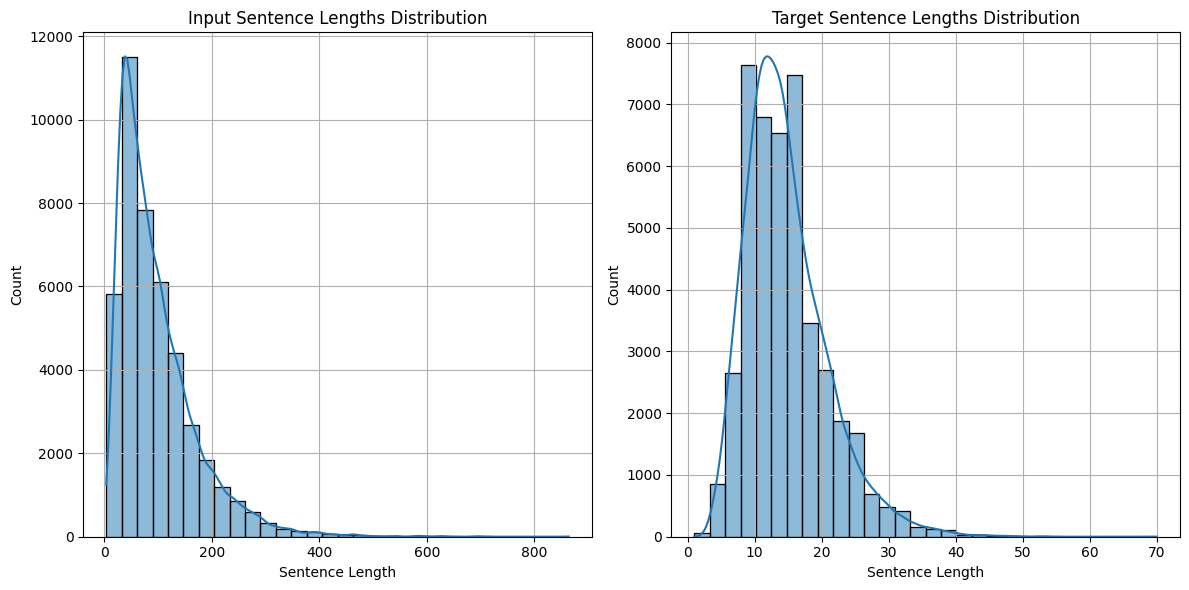

In [ ]:
#Visualize the distribution of the length of the input sentences 
plt.figure(figsize=(12, 6));
plt.subplot(1, 2, 1);
sns.histplot(train_input_lengths,kde=True,bins=30);
plt.title("Input Sentence Lengths Distribution");
plt.xlabel("Sentence Length");
plt.grid();

#Visualize the distribtuion of the length of the target sentences
plt.subplot(1, 2, 2);
sns.histplot(train_target_lengths,kde=True,bins=30);
plt.title("Target Sentence Lengths Distribution");
plt.xlabel("Sentence Length");
plt.grid();
plt.tight_layout();
plt.show();


The number of highlighted cells per row distribution

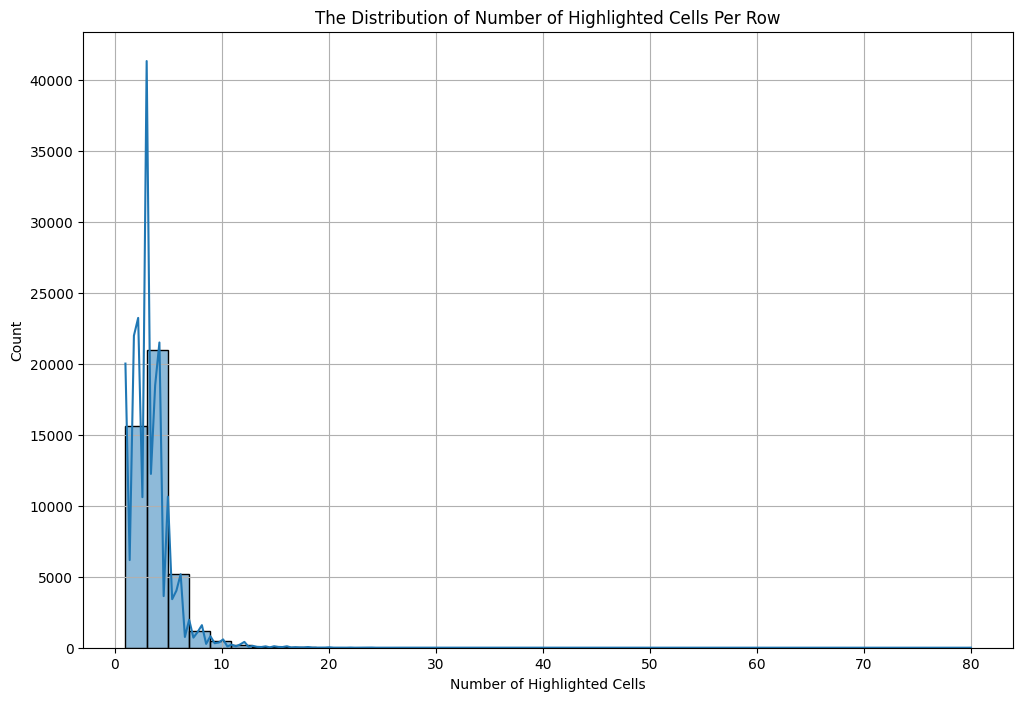

In [ ]:
#Visualize the distribution of the number of highlighted cells per row
highlight_counts = [len(row.get('highlighted_cells',[])) for row in train_data]
plt.figure(figsize=(12, 8));
sns.histplot(highlight_counts,kde=True,bins=40);
plt.title("The Distribution of Number of Highlighted Cells Per Row");
plt.xlabel("Number of Highlighted Cells");
plt.grid();
plt.show();

Create a word cloud

In [18]:
def remove_excluded_words(text_list,exclusions_list):
    pattern = r'\b('+'|'.join(re.escape(word) for word in exclusions_list)+r')\b'
    cleaned_text_list = [re.sub(pattern,'',line) for line in text_list]
    return cleaned_text_list

In [19]:
input_list_of_exclusions = ['hl','<hl>','</hl>','None']
EDA_cleaned_train_input_list = remove_excluded_words(EDA_train_input_list,input_list_of_exclusions)

all_input_text = ' '.join(EDA_cleaned_train_input_list)
all_target_text = ' '.join(train_target_list)

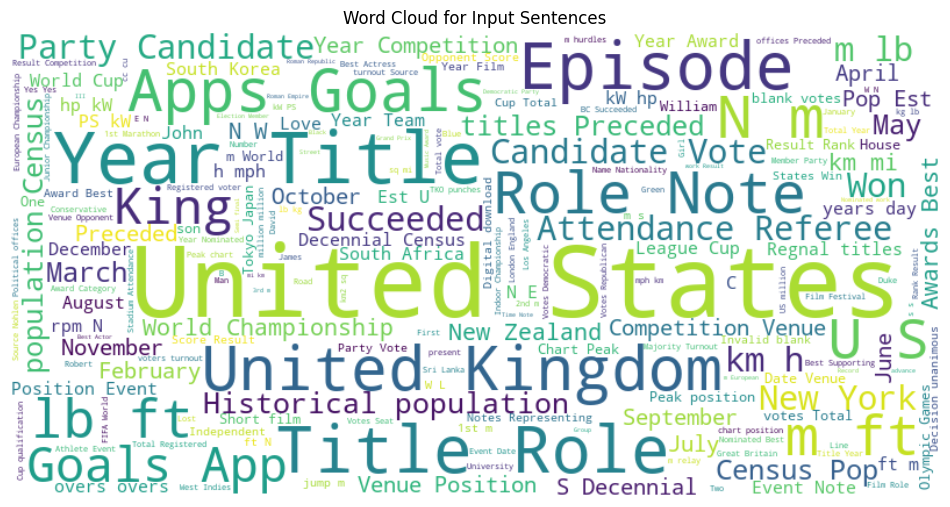

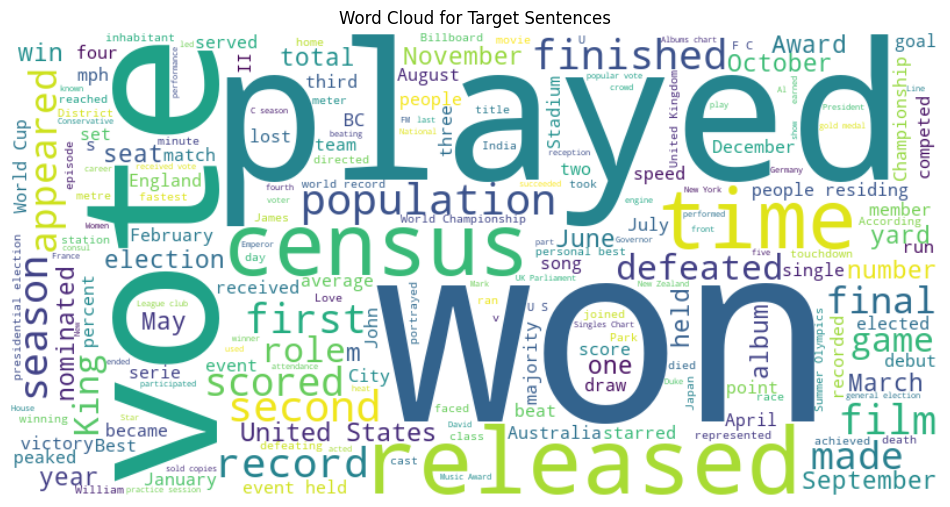

In [ ]:
#Word cloud for the input sentences
wordcloud_input = WordCloud(width=800,height=400,background_color='white').generate(all_input_text)
plt.figure(figsize=(12, 8));
plt.imshow(wordcloud_input, interpolation='bilinear');
plt.axis('off');
plt.title("Word Cloud for Input Sentences");
plt.show();

#Word cloud for the target sentences
wordcloud_target = WordCloud(width=800,height=400,background_color='white').generate(all_target_text)
plt.figure(figsize=(12, 8));
plt.imshow(wordcloud_target, interpolation='bilinear');
plt.axis('off');
plt.title("Word Cloud for Target Sentences");
plt.show();

Examine the correlation between input and target sentence lengths

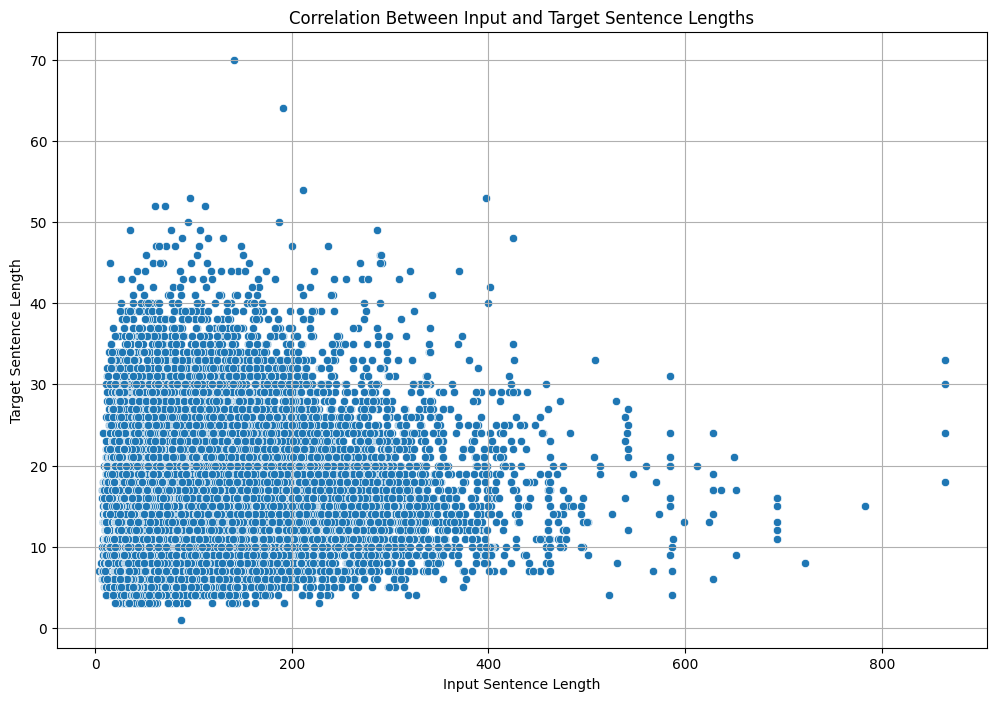

In [ ]:
#Visualize the correlation between input and target sentence lengths
plt.figure(figsize=(12, 8));
sns.scatterplot(x=train_input_lengths,y=train_target_lengths);
plt.title("Correlation Between Input and Target Sentence Lengths");
plt.xlabel("Input Sentence Length");
plt.ylabel("Target Sentence Length");
plt.grid();
plt.show();

###Prepare The Dataset

In [ ]:
#Initialize tokenizer and model
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-small")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-small")

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Creating a custom dataset

In [23]:
class TextDataset(Dataset):

    def __init__(self,input_list,target_list,tokenizer,max_input_length=512,max_target_length=512):
        self.input_list = input_list
        self.target_list = target_list
        self.tokenizer = tokenizer
        self.max_input_length = max_input_length
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.input_list)

    def __getitem__(self,idx):
        input_text = self.input_list[idx]
        target_text = self.target_list[idx]

        input_encodings = self.tokenizer(input_text,max_length=self.max_input_length,truncation=True,padding='max_length',return_tensors="pt")
        target_encodings = self.tokenizer(target_text,max_length=self.max_target_length,truncation=True,padding='max_length',return_tensors="pt")

        output_DICT = {
            'input_ids': input_encodings['input_ids'].squeeze(0),
            'attention_mask': input_encodings['attention_mask'].squeeze(0),
            'target_ids': target_encodings['input_ids'].squeeze(0)
        }

        return output_DICT

Split into training and validation

In [24]:
set_seed()
train_input_split, train_target_split, valid_input_split, valid_target_split = split_data(train_input_list,train_target_list)

In [25]:
print(len(train_input_split))
print(len(valid_input_split))

35056
8764


Split into batches

In [ ]:
#Create DataLoader for training 
train_dataset = TextDataset(train_input_split,train_target_split,tokenizer,max_input_length=512,max_target_length=512)
train_loader = DataLoader(train_dataset,batch_size=16,shuffle=True)

#Create DataLoader for validation 
val_dataset = TextDataset(valid_input_split,valid_target_split,tokenizer,max_input_length=512,max_target_length=512)
val_loader = DataLoader(val_dataset,batch_size=16,shuffle=False)

###Train The Model

In [ ]:
#Custom training loop
def train_model(model,train_loader,val_loader,num_epochs,patience_num_epochs=3):
    device = setup_device()
    model = model.to(device)
    optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)
    num_training_steps = len(train_loader)*num_epochs
    num_warmup_steps = int(0.1*num_training_steps)
    scheduler = get_scheduler("linear",optimizer=optimizer,num_warmup_steps=num_warmup_steps,num_training_steps=num_training_steps)
    
    best_val_loss = np.inf
    num_epochs_without_improvement = 0
    early_stopping = False

    performance_metrics_DICT = {
        "epoch_list": [],
        "train_loss_list": [],
        "val_loss_list": []    
    }
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for data in train_loader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            target_ids = data['target_ids'].to(device)

            optimizer.zero_grad()

            outputs = model(input_ids=input_ids,attention_mask=attention_mask,labels=target_ids)
            loss = outputs.loss
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(),max_norm=1)            
            optimizer.step()
            scheduler.step()
            
            running_loss += loss.item()

        train_loss = running_loss/len(train_loader)
        performance_metrics_DICT['train_loss_list'].append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for data in val_loader:
                input_ids = data['input_ids'].to(device)
                attention_mask = data['attention_mask'].to(device)
                target_ids = data['target_ids'].to(device)

                outputs = model(input_ids=input_ids,attention_mask=attention_mask,labels=target_ids)
                val_loss += outputs.loss.item()

        val_loss = val_loss/len(val_loader)
        performance_metrics_DICT['val_loss_list'].append(val_loss)

        performance_metrics_DICT['epoch_list'].append(epoch+1)
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(),"best_flan_T5_model.pt")
            save_json(performance_metrics_DICT,'flan_T5_performance_metrics_DICT.json')
            num_epochs_without_improvement = 0
            best_model_weights = model.state_dict()
        else:
            num_epochs_without_improvement += 1

        if num_epochs_without_improvement >= patience_num_epochs:
            print(f'Early stopping occurred at epoch {epoch + 1}')
            early_stopping = True
            break

    if early_stopping:
        model.load_state_dict(best_model_weights)
    print("Selected the best model weights from early stopping.")
    
    return performance_metrics_DICT

In [28]:
performance_metrics_DICT = train_model(model,train_loader,val_loader,num_epochs=40)

/opt/conda/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch 1/40, Train Loss: 13.9839, Val Loss: 0.1599
Epoch 2/40, Train Loss: 0.1341, Val Loss: 0.0999
Epoch 3/40, Train Loss: 0.1091, Val Loss: 0.0946
Epoch 4/40, Train Loss: 0.1027, Val Loss: 0.0907
Epoch 5/40, Train Loss: 0.0982, Val Loss: 0.0884
Epoch 6/40, Train Loss: 0.0949, Val Loss: 0.0867
Epoch 7/40, Train Loss: 0.0924, Val Loss: 0.0854
Epoch 8/40, Train Loss: 0.0904, Val Loss: 0.0846
Epoch 9/40, Train Loss: 0.0887, Val Loss: 0.0838
Epoch 10/40, Train Loss: 0.0872, Val Loss: 0.0833
Epoch 11/40, Train Loss: 0.0859, Val Loss: 0.0828
Epoch 12/40, Train Loss: 0.0847, Val Loss: 0.0822
Epoch 13/40, Train Loss: 0.0835, Val Loss: 0.0818
Epoch 14/40, Train Loss: 0.0826, Val Loss: 0.0816
Epoch 15/40, Train Loss: 0.0818, Val Loss: 0.0815
Epoch 16/40, Train Loss: 0.0809, Val Loss: 0.0810
Epoch 17/40, Train Loss: 0.0802, Val Loss: 0.0809
Epoch 18/40, Train Loss: 0.0794, Val Loss: 0.0806
Epoch 19/40, Train Loss: 0.0787, Val Loss: 0.0803
Epoch 20/40, Train Loss: 0.0782, Val Loss: 0.0803
Epoch 21

Load model and performance metrics

In [ ]:
#Load the best model for evaluation
def load_model():
    model.load_state_dict(torch.load("best_flan_T5_model.pt"))
    model.eval()

    device = setup_device()
    model.to(device)
    return model,device

In [30]:
performance_metrics_DICT = load_json('flan_T5_performance_metrics_DICT.json')
model,device = load_model()

/tmp/ipykernel_4762/1286370368.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_flan_T5_model.pt"))


Plot training and validation loss

In [ ]:
#Visualize the train and validation loss
def plot_train_valid(model_name,performance_metrics_DICT):
    plt.figure();
    plt.plot(performance_metrics_DICT['epoch_list'], performance_metrics_DICT['train_loss_list'], label=f'Train Loss', color='blue', linestyle='--', marker='o');
    plt.plot(performance_metrics_DICT['epoch_list'], performance_metrics_DICT['val_loss_list'], label=f'Validation Loss', color='green', linestyle='-', marker='x');
    plt.title(f'{model_name} Training and Validation Loss');
    plt.xlabel('Epochs');
    plt.ylabel('Loss');
    plt.legend();
    plt.grid();
    plt.xlim(0,max(performance_metrics_DICT['epoch_list'])+1);
    return

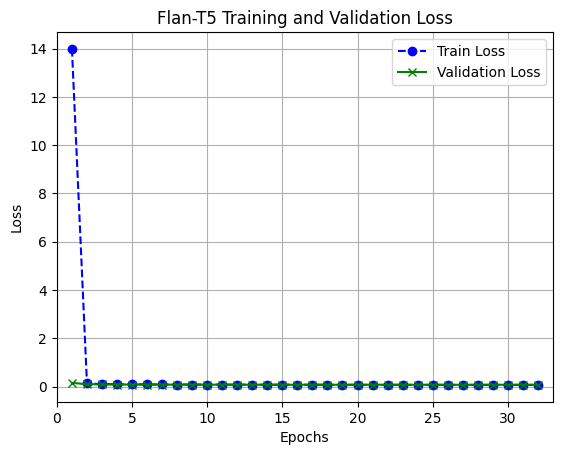

In [34]:
model_name = 'Flan-T5'

plot_train_valid(model_name,performance_metrics_DICT)

###Generate outputs

In [ ]:
#Function to generate a single output
def generate_single_output(model,tokenizer,input_text,device,max_input_length=512,max_target_length=512):
    model.eval()

    input_encodings = tokenizer(input_text,max_length=max_input_length,truncation=True,padding='max_length',return_tensors="pt").to(device)
    
    with torch.no_grad():
        generated_ids = model.generate(input_ids=input_encodings['input_ids'],attention_mask=input_encodings['attention_mask'],max_length=max_target_length,num_beams=5,early_stopping=True)

    output_text = tokenizer.decode(generated_ids[0],skip_special_tokens=True)
    return output_text

In [ ]:
#Function to generate all outputs
def generate_all_outputs(model,tokenizer,test_input_list,test_target_list,max_input_length=512,max_target_length=512):
    device = setup_device()
    model.to(device)
    
    output_list = []
    for input_text,target_text in zip(test_input_list,test_target_list):
        output_text = generate_single_output(model,tokenizer,input_text,device,max_input_length,max_target_length)
        output_list.append(output_text)
    save_json(output_list,'model_output_list.json')
    return output_list

In [ ]:
#Visualize outputs
def print_examples(test_input_list,test_target_list,output_list,num_examples=5):
    for i in range(num_examples):
        print(f'########################Example {i} ########################')
        print('Input Text:')
        print(test_input_list[i])
        print()
        print('Target Text:')
        print(test_target_list[i])
        print()
        print('Generated Text:')
        print(output_list[i])
        print()
    return

In [38]:
output_list = generate_all_outputs(model,tokenizer,test_input_list,test_target_list)

In [39]:
print_examples(test_input_list,test_target_list,output_list)

######################## Example 0 ########################
Input Text:
Generate a summary of the following table:
Year | Title | Role | Notes
2006 | Re-Animated | Dancer | 
2007 | High School Musical 2 | Dancer | 
2010 | My Name Is Khan | Tim Tompson | Bollywood film
2010 | Flipped | Matt Baker | 
2011 | Game Time: Tackling the Past | Sean Tate | 
2014 | God's Not Dead | Josh Wheaton | 
2014 | Dance-off | Brandon | 
2015 | Lift Me Up | Stephen | 
2016 | An Apprentice | Only director | Short film
2017 | Flock of Four | Sam Grover | 
<hl>2018</hl> | <hl>God's Not Dead: A Light in Darkness</hl> | <hl>Josh Wheaton</hl> |

Target Text:
In 2018, Harper starred as Josh Wheaton in God's Not Dead: A Light in Darkness. In 2018, Harper starred as Josh Wheaton in the film God's Not Dead: A Light in Darkness. In 2018, Harper starred as Josh Wheaton in the film God's Not Dead: A Light in Darkness.

Generated Text:
Josh Wheaton played Josh Wheaton in the 2018 film God's Not Dead: A Light in Darkness

Calculate performance metrics

In [40]:
def calculate_metrics(test_target_list,output_list):
    targets = [[target.split()] for target in test_target_list]
    outputs = [" ".join(output.split()) for output in output_list]
    
    bleu_metric = evaluate.load("bleu")
    rouge_metric = evaluate.load("rouge")
    meteor_metric = evaluate.load("meteor")

    bleu_result = bleu_metric.compute(predictions=outputs,references=targets)
    rouge_result = rouge_metric.compute(predictions=outputs,references=targets)
    meteor_result = meteor_metric.compute(predictions=outputs,references=targets)

    metrics_DICT = {
        'bleu_metric': bleu_result['bleu'],
        'rouge_1_metric': rouge_result['rouge1'],
        'rouge_2_metric': rouge_result['rouge2'],
        'rouge_L_metric': rouge_result['rougeL'],
        'meteor_metric': meteor_result['meteor']
    }

    metrics_DF = pd.DataFrame([metrics_DICT])
    save_CSV(metrics_DF,'metrics_DF.csv')
    return metrics_DF

In [41]:
metrics_DF = calculate_metrics(test_target_list,output_list)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
#Print the metrics on the test set
print(metrics_DF)

   bleu_metric  rouge_1_metric  rouge_2_metric  rouge_L_metric  meteor_metric
0     0.000053        0.312262        0.182342         0.29808       0.012555


In [43]:
metrics_DF = load_CSV('metrics_DF.csv')